# Box-least squares in Python

Based on algorithm by Kovacs, Zucker, and Mazeh [A&A 391, 369–377 (2002)](http://www.aanda.org/articles/aa/pdf/2002/31/aa2422.pdf)

Generate simulated data with white dwarf transits

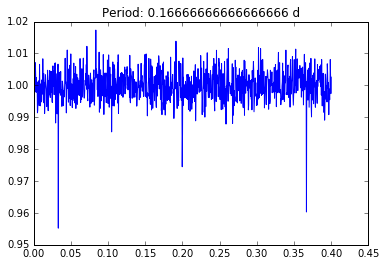

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import batman
import astropy.units as u
from astropy.constants import G, M_sun, R_earth

params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.2                        #time of inferior conjunction
params.per = 4./24                       #orbital period
params.rp = 0.2                       #planet radius (in units of stellar radii) 

# Assuming R_wd = R_earth, M_wd = 0.6 M_sun
a = (( (params.per*u.day)**2 / 
      (4*np.pi**2/(G*0.6*M_sun)))**(1./3)).to(R_earth).value 

params.a = a                        #semi-major axis (in units of stellar radii)
params.inc = 89.8                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients

t = np.linspace(0, 0.4, 1000)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model
f = m.light_curve(params)

rs = np.random.RandomState(seed=42)

errors = 0.0045*np.ones_like(f)
f += errors*rs.randn(len(t))

# Make `f` zero-mean

plt.plot(t, f)
plt.title("Period: {0} d".format(params.per))

Compute the BLS spectrum, find best period:

Recovered period: 0.16661661661661661
Actual period: 0.16666666666666666


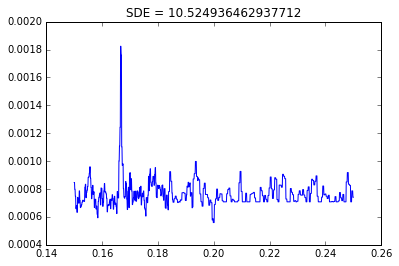

In [3]:
def signal_residue(folded_flux, folded_error, weights, i_1, i_2):
    """
    Calculate "Signal Residue", Eqn. 5
    """
    r = np.sum(weights[i_1:i_2])
    s = np.sum(weights[i_1:i_2] * folded_flux[i_1:i_2])
    return np.sqrt( s**2 / (r*(1 - r)) )

def calculate_weights(folded_errors):
    return folded_errors**-2 * np.sum(folded_errors**-2)**-1

def bls(times, fluxes, errors, min_period, max_period, 
        n_periods, transit_window):
    """
    Parameters
    ----------
    times : np.ndarray
        Times in time series
    fluxes : np.ndarray
        Fluxes at times `times`
    errors : np.ndarray
        Errors for each of `fluxes`
    min_period : float
        Test for periods longer than `min_period`
    max_period : float
        Test for periods shorter than `min_period`
    n_periods : int
        Test number of periods `n_periods` between `min_period` and `max_period`
    transit_window : int
        Fraction of orbital period in transit (not what's currently implemented)
        
    Returns
    -------
    trial_periods : np.ndarray
        Period grid tested for periodic signals via BLS
    spectrum : np.ndarray
        "Power" in BLS spectrum at each trial period
    """
    fluxes = fluxes.copy() - np.mean(fluxes)
    
    trial_periods = np.linspace(min_period, max_period, n_periods)

    spectrum = np.zeros(len(trial_periods))
    for i, trial_period in enumerate(trial_periods):
        folded_t = times % trial_period

        sorted_args = np.argsort(folded_t)
        folded_f = fluxes[sorted_args]
        folded_e = errors[sorted_args]
        weights = calculate_weights(folded_e)

        i1 = np.arange(len(times)-transit_window)
        i2 = np.arange(transit_window, len(times))

        sr = np.zeros(len(i1))

        for i_1, i_2 in zip(i1, i2):
            sr[i_1] = signal_residue(folded_f, folded_e, weights, i_1, i_2)

        spectrum[i] = np.max(sr)

    return trial_periods, spectrum

trial_periods, spectrum = bls(t, f, errors, 0.15, 0.25, 1000, 5)
signal_detection_efficiency = (np.max(spectrum) - np.mean(spectrum))/np.std(spectrum)
plt.plot(trial_periods, spectrum)
plt.title("SDE = {0}".format(signal_detection_efficiency))

print("Recovered period: {0}\nActual period: {1}"
      .format(trial_periods[np.argmax(spectrum)], params.per))

### Faster implementation with vectorization

This version is **35,000x faster** 

Recovered period: 0.16657165716571656
Actual period: 0.16666666666666666


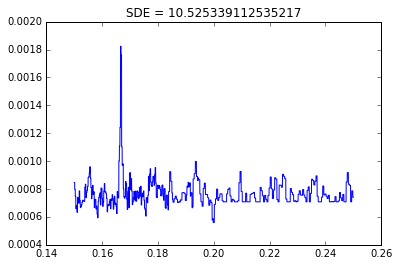

In [9]:
def strided_array(a, window_width):
    as_strided = np.lib.stride_tricks.as_strided

    #window_width = 4
    new_shape = (len(a) - window_width + 1, window_width)
    b = as_strided(a, new_shape, (a.strides[0], a.strides[0]))
    return b

def bls_strided(times, fluxes, errors, min_period, max_period, 
                n_periods, transit_window):
    """
    Parameters
    ----------
    times : np.ndarray
        Times in time series
    fluxes : np.ndarray
        Fluxes at times `times`
    errors : np.ndarray
        Errors for each of `fluxes`
    min_period : float
        Test for periods longer than `min_period`
    max_period : float
        Test for periods shorter than `min_period`
    n_periods : int
        Test number of periods `n_periods` between `min_period` and `max_period`
    transit_window : int
        Fraction of orbital period in transit (not what's currently implemented)
        
    Returns
    -------
    trial_periods : np.ndarray
        Period grid tested for periodic signals via BLS
    spectrum : np.ndarray
        "Power" in BLS spectrum at each trial period
    """
    fluxes = fluxes.copy() - np.mean(fluxes)
    
    trial_periods = np.linspace(min_period, max_period, n_periods)

    spectrum = np.zeros(len(trial_periods))
    for i, trial_period in enumerate(trial_periods):
        folded_t = times % trial_period

        sorted_args = np.argsort(folded_t)
        folded_f = fluxes[sorted_args]
        folded_e = errors[sorted_args]
        weights = calculate_weights(folded_e)

        strided_flux = strided_array(folded_f, transit_window)
        strided_error = strided_array(folded_e, transit_window)
        strided_weights = strided_array(weights, transit_window)
        
        r = np.sum(strided_weights, axis=1)
        s = np.sum(strided_weights * strided_flux, axis=1)
        SR = np.sqrt( s**2 / (r*(1 - r)) )
        spectrum[i] = np.max(SR)


    return trial_periods, spectrum

trial_periods, spectrum = bls_strided(t, f, errors, 0.15, 0.25, 10000, 5)
signal_detection_efficiency = (np.max(spectrum) - np.mean(spectrum))/np.std(spectrum)
plt.plot(trial_periods, spectrum)
plt.title("SDE = {0}".format(signal_detection_efficiency))

print("Recovered period: {0}\nActual period: {1}"
      .format(trial_periods[np.argmax(spectrum)], params.per))

In [6]:
%%timeit
bls_strided(t, f, errors, 0.15, 0.25, 1000, 5)

1 loops, best of 3: 210 ms per loop
